# <center>GSWAE</center>

Let $f$ be an encoder and $g$ a decoder. We want to put some prior $p_Z$. Denote $\mu$ the target distribtuion.  Then, [1] proposes to use as loss:
\begin{equation}
    \mathcal{L}(f,g) = \int c\big(x, g(f(x))\big) \mathrm{d}\mu(x) + \lambda \ GSW_2^2(f_\#\mu, p_Z).
\end{equation}

For the official implementation, see https://github.com/kimiandj/gsw.

[1] Kolouri, Soheil, et al. "Generalized sliced wasserstein distances." Advances in Neural Information Processing Systems 32 (2019). Kolouri, Soheil, et al. "Sliced Wasserstein auto-encoders." International Conference on Learning Representations. 2018.

In [1]:
import torch

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

from tqdm.auto import trange
from sklearn.datasets import make_circles

from sw import sliced_wasserstein

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### MNIST

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()#,
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=500, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

### AutoEncoder

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_filter, d=48):
        super().__init__()
        self.num_filter = num_filter
        self.conv1 = nn.Conv2d(1, self.num_filter, 
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(self.num_filter, self.num_filter, 
                               kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, padding=0)
        self.conv3 = nn.Conv2d(self.num_filter, self.num_filter*2,
                               kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(self.num_filter*2, self.num_filter*2,
                               kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, padding=0)
        self.conv5 = nn.Conv2d(self.num_filter*2, self.num_filter*4, 
                               kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(self.num_filter*4, self.num_filter*4,
                               kernel_size=3, padding=1)
        self.pool3 = nn.AvgPool2d(kernel_size=2, padding=1)        
        
        self.fc1 = nn.Linear(int(self.num_filter*4*4*4), 128)
        self.fc2 = nn.Linear(128, d)
                
        
    def forward(self, x):
        if len(x.shape) == 3:
            x = x[None, ...]

        out = F.leaky_relu(self.conv1(x), 0.2)
        out = self.pool1(F.leaky_relu(self.conv2(out), 0.2))
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = self.pool2(F.leaky_relu(self.conv4(out), 0.2))
        out = F.leaky_relu(self.conv5(out), 0.2)
        out = self.pool3(F.leaky_relu(self.conv6(out), 0.2))
        out = out.view(out.size(0), -1)
        out = torch.relu(self.fc1(out))
        return self.fc2(out)
    

class Decoder(nn.Module):
    def __init__(self, num_filter, bottleneck_size=48):
        super().__init__()
        self.num_filter = num_filter

        self.fc4 = nn.Linear(bottleneck_size, 128)
        self.fc5 = nn.Linear(128, self.num_filter*4*4*4)
        
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv1 = nn.Conv2d(self.num_filter*4, self.num_filter*4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(self.num_filter*4, self.num_filter*4, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(self.num_filter*4, self.num_filter*4, kernel_size=3, padding=0)
        self.conv4 = nn.Conv2d(self.num_filter*4, self.num_filter*2, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(self.num_filter*2, self.num_filter*2, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(self.num_filter*2, 1, kernel_size=3, padding=1)
    
    def forward(self, x):
        d = self.num_filter
        out = torch.relu(self.fc5(self.fc4(x)))
        out = out.view(-1, 4*d, 4, 4)
        
        out = F.leaky_relu(self.conv1(self.upsample(out)), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(self.upsample(out)), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = F.leaky_relu(self.conv5(self.upsample(out)), 0.2)

        out = torch.sigmoid(self.conv6(out))
        return out
    
    
class AE(nn.Module):
    def __init__(self, input_shape, d=48):
        super().__init__()
        self.encoder = Encoder(input_shape, d)
        self.decoder = Decoder(input_shape, d)
    
    def forward(self, x):
        z = self.encoder(x)        
        y = self.decoder(z)
        return y

In [5]:
## https://github.com/eifuentes/swae-pytorch/blob/763f771c1d4860f71819af48d4f21a8a29a689d5/swae/distributions.py#L38

def rand_ring2d(batch_size):
    """ This function generates 2D samples from a hollowed-cirlce distribution in a 2-dimensional space.
        Args:
            batch_size (int): number of batch samples
        Return:
            torch.Tensor: tensor of size (batch_size, 2)
    """
    circles = make_circles(2 * batch_size, noise=.01)
    z = np.squeeze(circles[0][np.argwhere(circles[1] == 0), :])
    return torch.from_numpy(z).type(torch.FloatTensor)


def rand_circle2d(batch_size):
    """ This function generates 2D samples from a filled-circle distribution in a 2-dimensional space.
        Args:
            batch_size (int): number of batch samples
        Return:
            torch.Tensor: tensor of size (batch_size, 2)
    """
    r = np.random.uniform(size=(batch_size))
    theta = 2 * np.pi * np.random.uniform(size=(batch_size))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.array([x, y]).T
    return torch.from_numpy(z).type(torch.FloatTensor)

In [6]:
def val_mnist(model, latent_dim=2, latent_distr="unif"):
    model.eval()

    torch.manual_seed(42)
    r,c = 5,5
    if latent_distr == "unif":
        z = -1+2*torch.rand(r*c, latent_dim, device=device)
    elif latent_distr == "ring":
#         g = torch.randn(n, d, device=device)
#         z = F.normalize(g, p=2, dim=1)
        z = rand_ring2d(r*c).to(device)
    elif latent_distr == "circle":
        z = rand_circle2d(r*c).to(device)
        
    gen_imgs = model.decoder(z).reshape(-1,28,28).detach().cpu()

    cpt = 0
    fig,ax = plt.subplots(r,c)
    for i in range(r):
        for j in range(c):
            ax[i,j].imshow(gen_imgs[cpt],"gray")
            ax[i,j].axis('off')

            cpt += 1
                
    fig.set_size_inches(6, 6)
    plt.tight_layout()
    plt.show()

In [7]:
def plot_latent(model, test_loader):
    model.eval()

    test_encode, test_targets = [], []
    for x_val, y_val in test_loader:
        x_val = x_val.to(device)

        zhat = model.encoder(x_val)
        yhat = model.decoder(zhat)
        test_encode.append(zhat.detach())
        test_targets.append(y_val.detach())
    
    test_encode = torch.cat(test_encode).cpu().numpy()
    test_targets = torch.cat(test_targets).cpu().numpy()
    
    # Distribution of the encoded samples
    z = test_encode
    Y = test_targets

    plt.figure(figsize=(10,10))
    plt.scatter(z[:,0], -z[:,1], c=10*Y, cmap=plt.cm.Spectral)
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.show()

In [9]:
def train(model, optimizer, n_epochs, train_loader, test_loader, latent_distr="unif", plot_val=False):
    pbar = trange(n_epochs)

    losses = []
    val_losses = []

    for e in pbar:
        loss_epoch = 0
        cpt_batch = 0

        for x_batch, _ in train_loader:
            x_batch = x_batch.to(device)

            model.train()

            z_hat = model.encoder(x_batch)
            y_hat = model.decoder(z_hat)

            l = ae_loss(x_batch, y_hat, z_hat, latent_distr)
            l.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_epoch += l.item()/x_batch.size(0)
            cpt_batch += 1

        losses.append(loss_epoch/cpt_batch)

        loss_val_epoch = 0
        cpt_batch = 0

        with torch.no_grad():
            for x_val, _ in test_loader:
                x_val = x_val.to(device)

                model.eval()
                zhat = model.encoder(x_val)
                yhat = model.decoder(zhat)
                val_l = ae_loss(x_val,yhat,zhat,latent_distr)
                loss_val_epoch += val_l.item()/x_val.size(0)
                cpt_batch += 1

            val_losses.append(loss_val_epoch/cpt_batch)

        print(e,losses[-1],val_losses[-1])

        if e%10 == 0 and plot_val:  
            with torch.no_grad():
                model.eval()
                for x_val, _ in test_loader:
                    fig,ax = plt.subplots(1,2,figsize=(10,10))

                    ax[0].imshow(x_val[0][0],"gray")

                    x_val = x_val.to(device)

                    model.eval()
                    yhat = model(x_val[0][0].reshape(-1,28,28))
                    yhat = yhat.reshape(-1,1,28,28)
                    ax[1].imshow(yhat[0][0].cpu().detach().numpy(),"gray")
                    plt.show()

                    break

                plot_latent(model, test_loader)
                
    if plot_val:
        plt.plot(losses, label="Training loss")
        plt.plot(val_losses, label="Validation loss")
        plt.legend()
        plt.show()


### GSWAE

In [54]:
from sw import emd1D

In [88]:
def get_powers(dim, degree):
    '''
    This function calculates the powers of a homogeneous polynomial
    e.g.
    list(get_powers(dim=2,degree=3))
    [(0, 3), (1, 2), (2, 1), (3, 0)]
    list(get_powers(dim=3,degree=2))
    [(0, 0, 2), (0, 1, 1), (0, 2, 0), (1, 0, 1), (1, 1, 0), (2, 0, 0)]
    
    https://github.com/kimiandj/gsw/blob/9f7f0ce6ae74049cb9ed753c34a6deff14cd4417/code/gsw/gsw.py#L149
    '''
    if dim == 1:
        yield (degree,)
    else:
        for value in range(degree + 1):
            for permutation in get_powers(dim - 1,degree - value):
                yield (value,) + permutation
                

def homopoly(dim, degree):
    '''
    calculates the number of elements in a homogeneous polynomial
    
    https://github.com/kimiandj/gsw/blob/9f7f0ce6ae74049cb9ed753c34a6deff14cd4417/code/gsw/gsw.py#L149
    '''
    return len(list(get_powers(dim,degree)))


def g_poly(X, theta, device, degree=3):
    ''' The polynomial defining function for generalized Radon transform
        Inputs
        X:  Nxd matrix of N data samples
        theta: Lxd vector that parameterizes for L projections
        degree: degree of the polynomial
        
        https://github.com/kimiandj/gsw/blob/9f7f0ce6ae74049cb9ed753c34a6deff14cd4417/code/gsw/gsw.py#L149
    '''
    N, d = X.shape
    assert theta.shape[1]==homopoly(d, degree)
    powers=list(get_powers(d, degree))
    HX=torch.ones((N, len(powers))).to(device)
    for k,power in enumerate(powers):
        for i,p in enumerate(power):
            HX[:,k]*=X[:,i]**p
    if len(theta.shape)==1:
        return torch.matmul(HX,theta)
    else:
        return torch.matmul(HX,theta.t())

In [80]:
def g_circular(x, theta, radius=2):
    """
        https://github.com/kimiandj/gsw/blob/9f7f0ce6ae74049cb9ed753c34a6deff14cd4417/code/gsw/gsw.py#L149
    """
    theta = torch.stack([radius*th for th in theta])
    return torch.stack([torch.sqrt(torch.sum((x-th)**2,dim=1)) for th in theta],1)

In [100]:
def sliced_cost(Xs, Xt, ftype="linear", projections=None, u_weights=None, v_weights=None, p=1):

    if projections is not None and ftype == "linear":
        Xps = (Xs @ projections).T
        Xpt = (Xt @ projections).T
    elif projections is not None and ftype == "circular":
        Xps = g_circular(Xs, projections.T).T
        Xpt = g_circular(Xt, projections.T).T
    elif projections is not None and ftype=="poly":
        Xps = g_poly(Xs, projections.T, device=Xs.device).T
        Xpt = g_poly(Xt, projections.T, device=Xt.device).T
    else:
        Xps = Xs.T
        Xpt = Xt.T
                
    return torch.mean(emd1D(Xps,Xpt,
                       u_weights=u_weights,
                       v_weights=v_weights,
                       p=p))


def sliced_wasserstein(Xs, Xt, num_projections, device,
                       u_weights=None, v_weights=None, p=1, 
                       ftype="linear", degree=3):
    num_features = Xs.shape[1]

    # Random projection directions, shape (num_features, num_projections)
    if ftype=="poly":
        dpoly = homopoly(num_features, degree)
        projections = np.random.normal(size=(dpoly, num_projections))
    else:
        projections = np.random.normal(size=(num_features, num_projections))
    projections = F.normalize(torch.from_numpy(projections), p=2, dim=0).type(Xs.dtype).to(device)

    return sliced_cost(Xs,Xt,projections=projections,
                       u_weights=u_weights,
                       v_weights=v_weights,
                       p=p, ftype=ftype)

#### GSWAE Circular

In [97]:
criterion = nn.BCELoss(reduction='mean')

def ae_loss(x, y, z, latent_distr="unif"):
    n, d = z.size()
    
    if latent_distr == "unif":
        target_latent = -1+2*torch.rand(n, d, device=device)
    elif latent_distr == "ring":
#         g = torch.randn(n, d, device=device)
#         target_latent = F.normalize(g, p=2, dim=1)
        target_latent = rand_ring2d(n).to(device)
    elif latent_distr == "circle":
        target_latent = rand_circle2d(n).to(device)

    sw = sliced_wasserstein(z, target_latent, 1000, device, p=2, ftype="circular")
#     l1 = F.l1_loss(y, x) # torch.mean(torch.abs(x-y))
    reconstruction_loss = criterion(y, x)    
    return reconstruction_loss+10.0*sw

  0%|          | 0/101 [00:00<?, ?it/s]

0 0.00202012891471386 0.04348121951825131


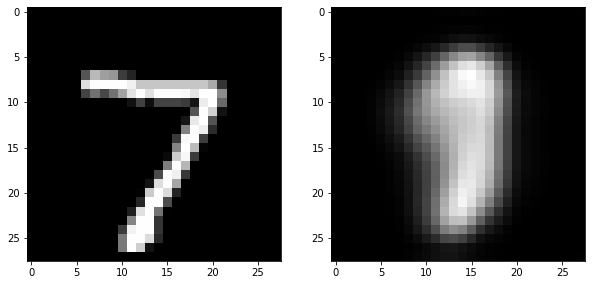

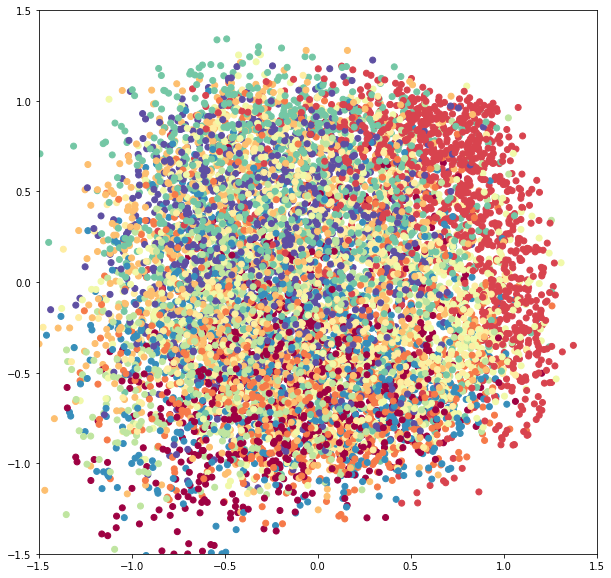

1 0.0006391970763603847 0.04412893096086221
2 0.0005978064283728603 0.04128330267263582
3 0.000582291281968355 0.042698935260430886
4 0.0006028946434458094 0.043203726550712945
5 0.0005470142627755803 0.03968864260092616
6 0.000538381666193406 0.04118485926998595
7 0.0005437211299935979 0.041412264287186126
8 0.000548183729251226 0.03782019483895538
9 0.0005452128760516645 0.03617706117681421
10 0.0005316705830395222 0.03689740731800421


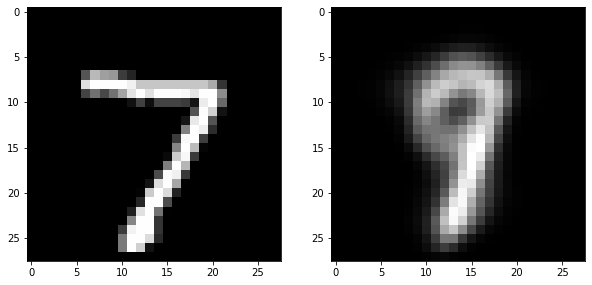

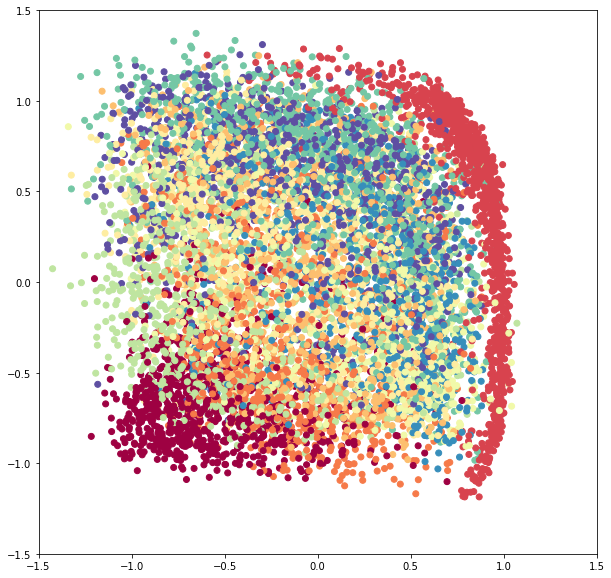

11 0.0005220636839667955 0.036892341979490685
12 0.0005130338008205097 0.033138697791380435
13 0.0005131531993548074 0.034017357400978526
14 0.000489456663529078 0.03209491069622029
15 0.00048792598073681197 0.033418995349075845
16 0.00048542481660842875 0.03152702785076234
17 0.0004914414527515571 0.03225907161177252
18 0.0004881905953089395 0.03145349459847608
19 0.0004872900580366454 0.030590355315933022
20 0.00048335393096009884 0.03255740203522741


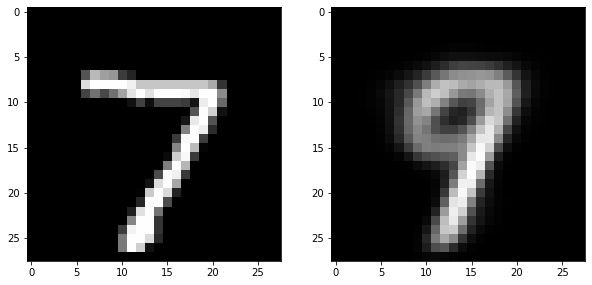

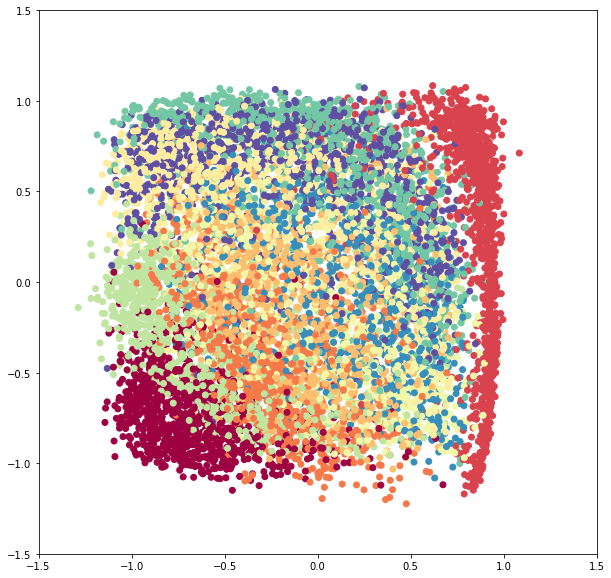

21 0.0004750628809134167 0.030797242005459798
22 0.0004766510320206484 0.0325833882916326
23 0.0004760587478677433 0.029935028490286095
24 0.00049081898778677 0.029898658579292768
25 0.0004905221653481323 0.030984397805013216
26 0.0004808001858492694 0.030113853945637852
27 0.00047792095169425005 0.03073505057206455
28 0.0004726060805221399 0.0299133700839342
29 0.0004729712451497711 0.02944614468053126
30 0.00046564656446377434 0.03004622251128617


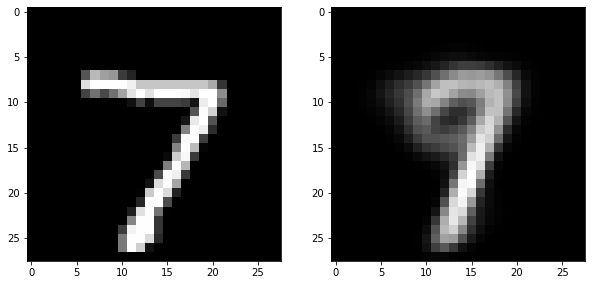

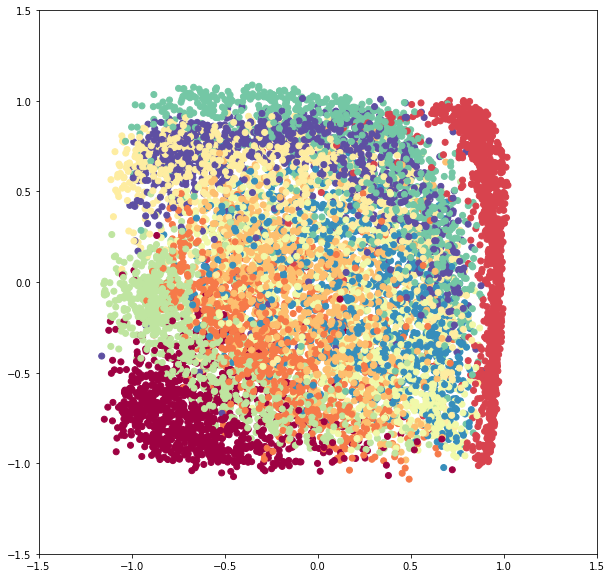

31 0.00046678122729063037 0.031210288438148583
32 0.0004647370206813017 0.03108546138999942
33 0.0004616068460047245 0.030220508090437602
34 0.00046537158836921046 0.029132248027422748
35 0.0004694184646010399 0.02897886545680011
36 0.0004543219683070979 0.029667971173700052
37 0.0004752880354722339 0.029196844278528287
38 0.00045953314378857613 0.028232368703086538
39 0.0004638348114987213 0.0295823823880797
40 0.0004625646114349364 0.030566521340046827


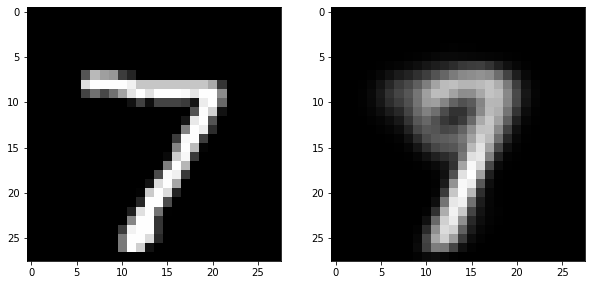

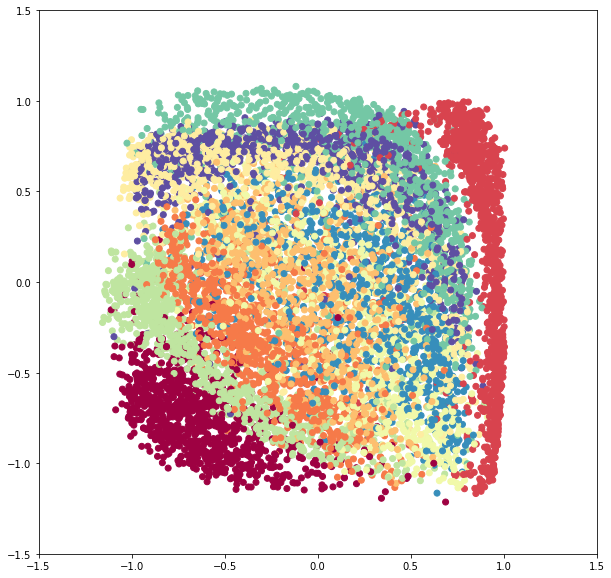

41 0.0004602362111210824 0.03048877682263097
42 0.0004571704347928364 0.030211942237667953
43 0.00045966014191508307 0.02843759315439497
44 0.00045479021842281017 0.029388319674177103
45 0.0004486137082179386 0.027953495753530306
46 0.00045150007928411185 0.030346701632792385
47 0.0004613294747968514 0.03033118906279151
48 0.00044991495857636145 0.029622848074252424
49 0.0004584644230703513 0.028924716571078132
50 0.00044654840926329297 0.03010174496390949


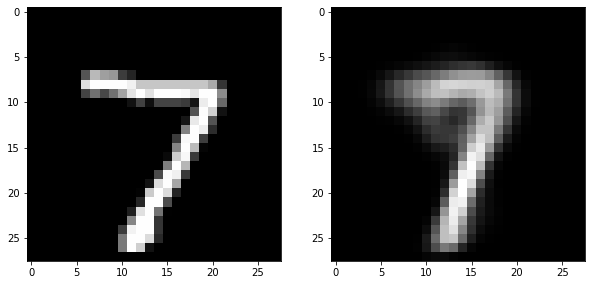

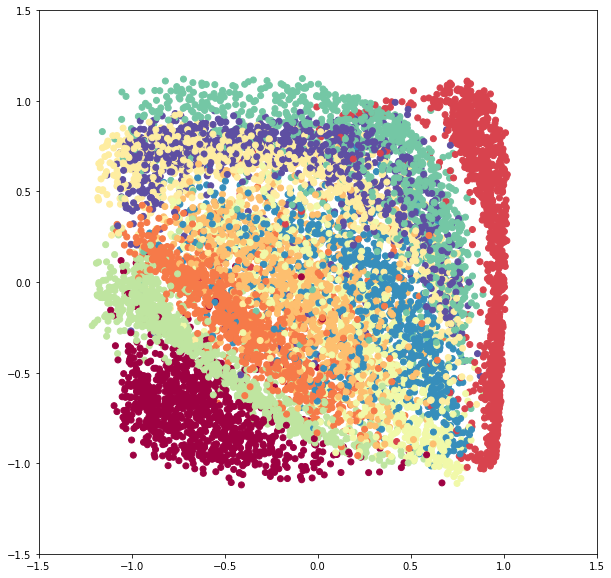

51 0.00044712170114119857 0.029108223963540774
52 0.00044518705730636917 0.029097802475832713
53 0.00044672238429387427 0.0280341099108608
54 0.00045084723432858777 0.028250536295219352
55 0.0004406442912916344 0.027695672366375358
56 0.0004488819509744644 0.02849274974602004
57 0.0004460213539501033 0.029688945397163352
58 0.0004411760804553827 0.028529859118211192
59 0.00043748113488157616 0.029804914154278966
60 0.0004471525999406976 0.029213894804279075


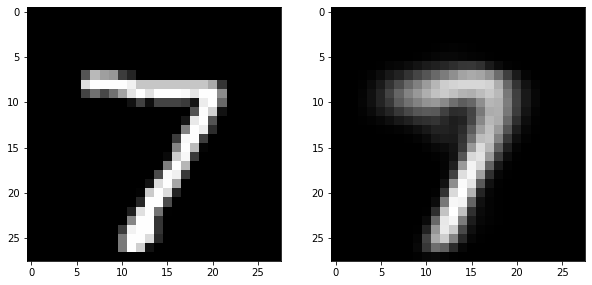

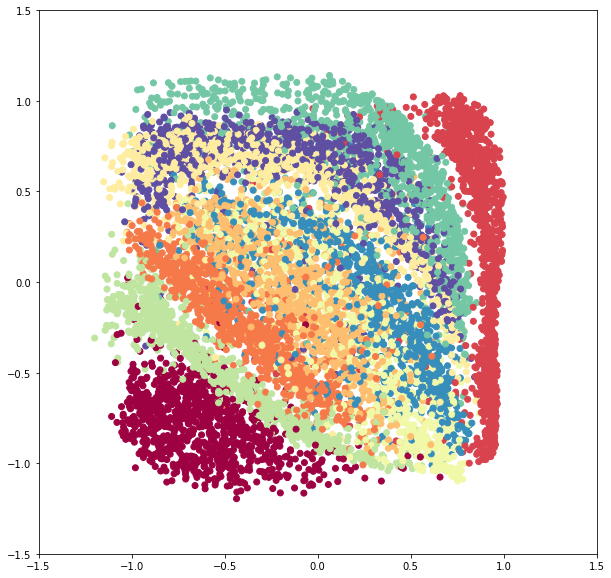

61 0.0004452361414829891 0.03048415538578178
62 0.0004357969634234904 0.02826686776853122
63 0.00043585380141933757 0.02929350013990467
64 0.000440538477152586 0.028493572187166624
65 0.0004326847684880099 0.03013481424984555
66 0.0004500927940011025 0.03016716939584611
67 0.00043594993352889994 0.028809499971497173
68 0.00042897531986236577 0.028872022899195028
69 0.00043989126359423014 0.02792551519926459
70 0.00042550704528888055 0.029123756873864717


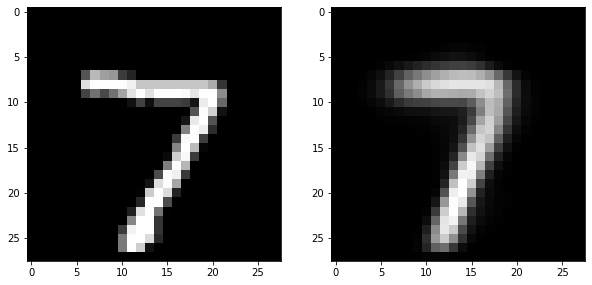

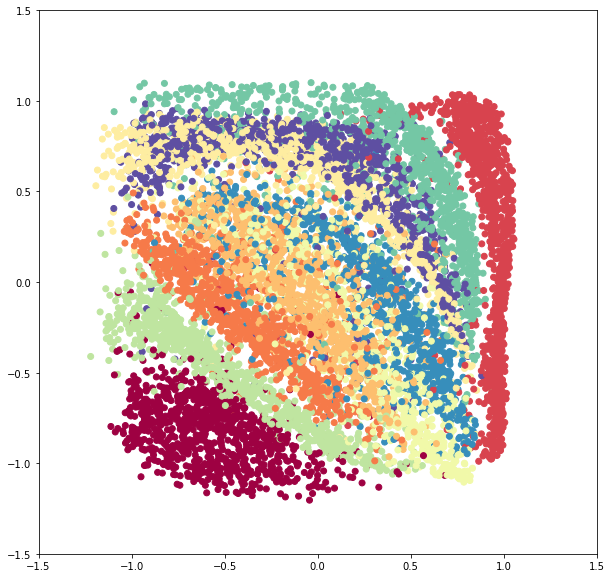

71 0.0004334317718942961 0.027421327620244827
72 0.00043539055685202274 0.028570594825445654
73 0.00042293097401658664 0.02955034756348632
74 0.00043666193311413124 0.027674504261190138
75 0.000428063325583935 0.028853869297729134
76 0.000441544396430254 0.02737425388500523
77 0.00042996080915133183 0.02823916357010603
78 0.00043632760395606357 0.029260049151560177
79 0.0004329392112791538 0.028736457317924728
80 0.00042565721323092784 0.02904309706685071


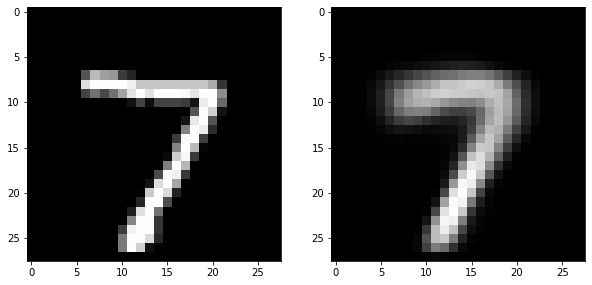

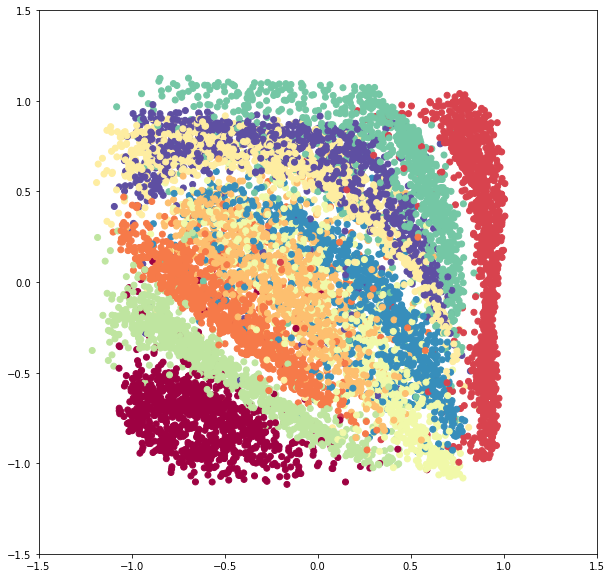

81 0.0004273382005592187 0.02941410800817009
82 0.00043781369055310895 0.028293257409605546
83 0.0004237693955500919 0.028228745176888313
84 0.0004258782898386319 0.02732506343208182
85 0.00042917605862021434 0.028785008270614827
86 0.0004328201293945311 0.029838585220396327
87 0.0004253840193152427 0.027987311353175025
88 0.00043127976556619037 0.030042678201065275
89 0.0004221434990564983 0.028724484487820546
90 0.0004267845995724202 0.028679270074128533


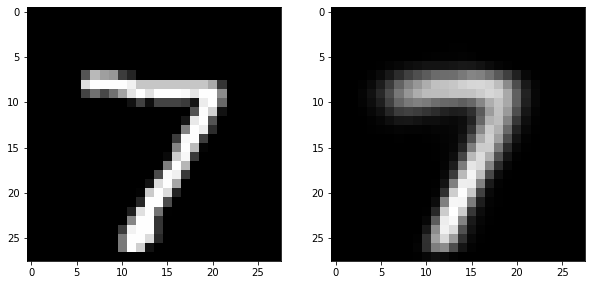

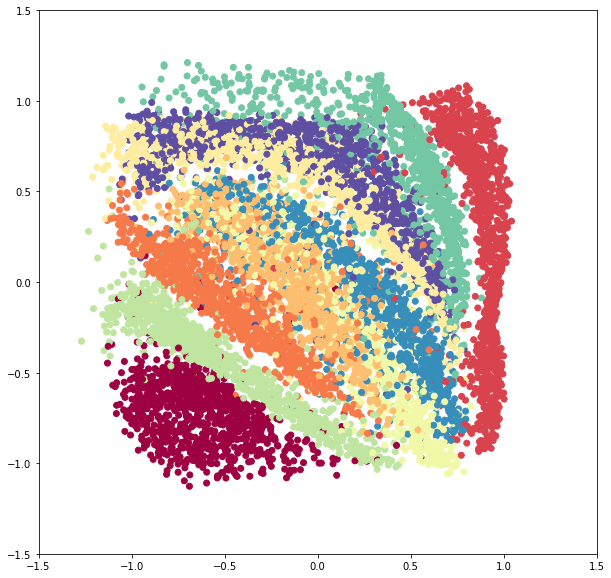

91 0.0004282440920670828 0.02804557245058088
92 0.00042838191837072374 0.028568616327338706
93 0.00042364316036303846 0.028404703637519582
94 0.0004280848885575928 0.028121589200969892
95 0.0004233279454211394 0.02753267047135308
96 0.00042245505973696735 0.028842858687495462
97 0.0004245785549283028 0.028481948501861896
98 0.0004250194018085796 0.028665307123725788
99 0.00041647947008411105 0.028642989873600463
100 0.0004220757861932118 0.028595822839477


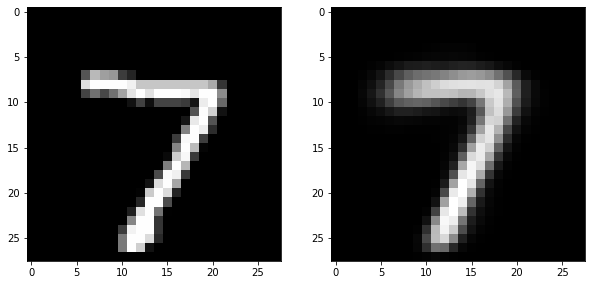

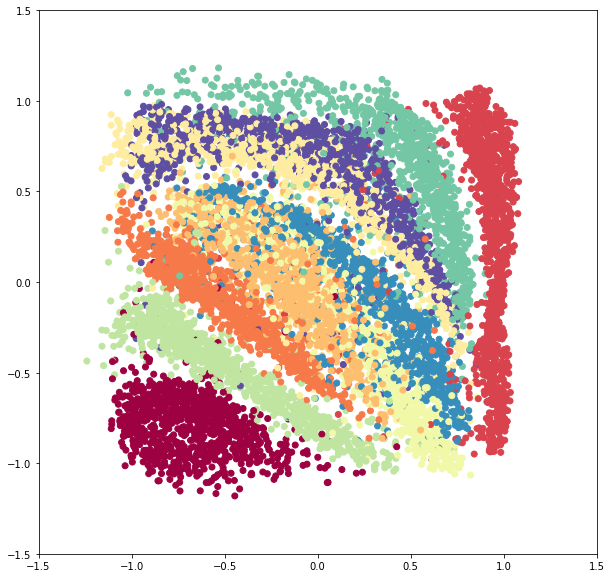

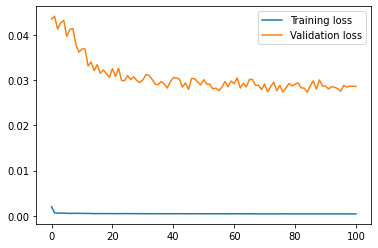

In [63]:
model = AE(16, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model, optimizer, 101, train_loader, test_loader, "unif", True)

#### GSWAE Polynomial

In [101]:
criterion = nn.BCELoss(reduction='mean')

def ae_loss(x, y, z, latent_distr="unif"):
    n, d = z.size()
    
    if latent_distr == "unif":
        target_latent = -1+2*torch.rand(n, d, device=device)
    elif latent_distr == "ring":
#         g = torch.randn(n, d, device=device)
#         target_latent = F.normalize(g, p=2, dim=1)
        target_latent = rand_ring2d(n).to(device)
    elif latent_distr == "circle":
        target_latent = rand_circle2d(n).to(device)

    sw = sliced_wasserstein(z, target_latent, 1000, device, p=2, ftype="poly")
#     l1 = F.l1_loss(y, x) # torch.mean(torch.abs(x-y))
    reconstruction_loss = criterion(y, x)    
    return reconstruction_loss+10.0*sw

  0%|          | 0/101 [00:00<?, ?it/s]

0 0.002448820474743845 0.03453880774613006


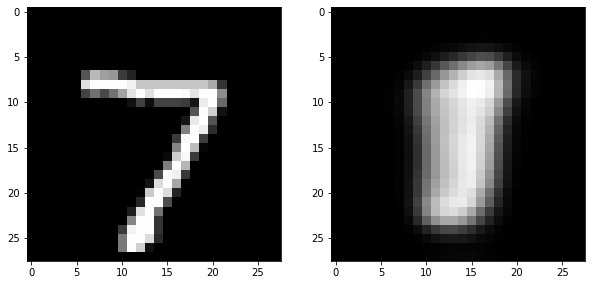

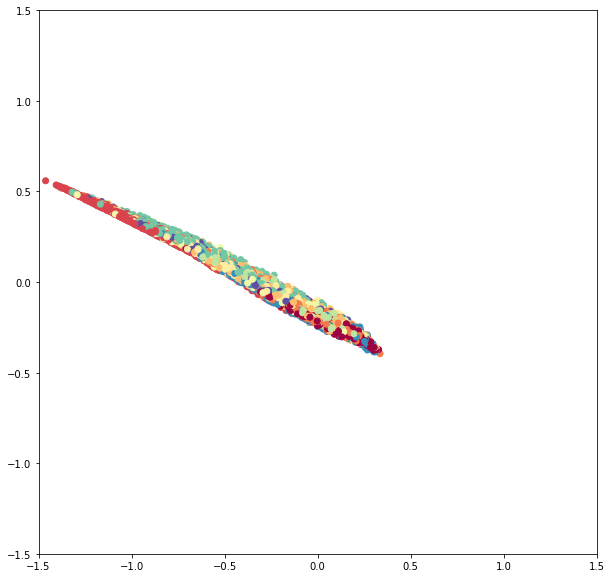

1 0.0010800682316223777 0.021288003412465128
2 0.0005643224067986013 0.019901004560386983
3 0.0005144672016302745 0.01870464660620061
4 0.0005224471102158231 0.020337406798792534
5 0.0005048144084711872 0.019405711004837824
6 0.000496345394849777 0.02116828682883003
7 0.0004893306848903495 0.019638431624482616
8 0.0004902273056407769 0.0199428376929162
9 0.0004899654095371567 0.017722043089759044
10 0.0004883622445166108 0.018497636639914765


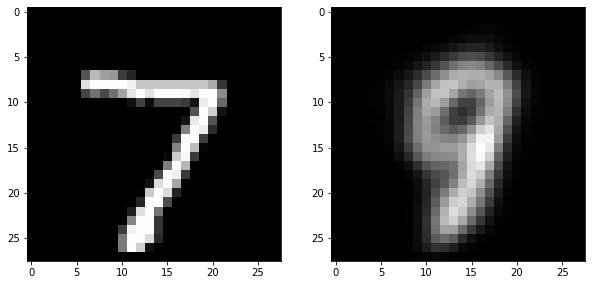

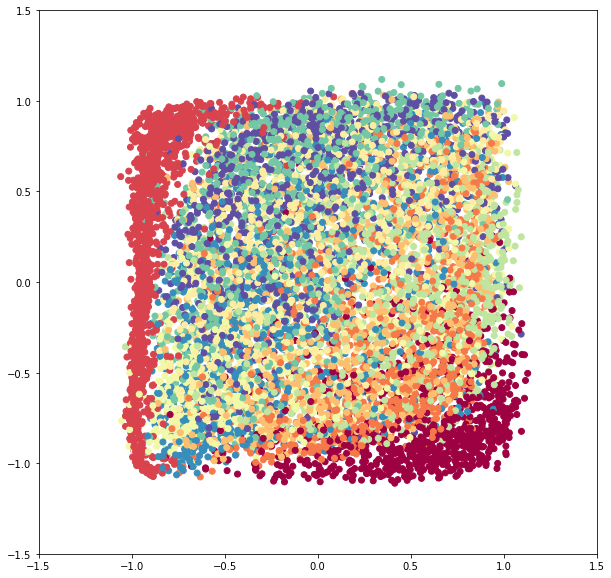

11 0.0004736596318582693 0.017364840240429003
12 0.0004866480641067027 0.017422400813656876
13 0.0004731385538975398 0.01767091864285568
14 0.0004773548133671283 0.01751856728138539
15 0.0004685564393798511 0.0169782296162301
16 0.0004775862636665504 0.017306093406229735
17 0.0004695153129597504 0.0180186668541818
18 0.00045791376059253996 0.016533033020746785
19 0.00046301465158661174 0.017689266224234057
20 0.00047836242467165 0.019819319310684366


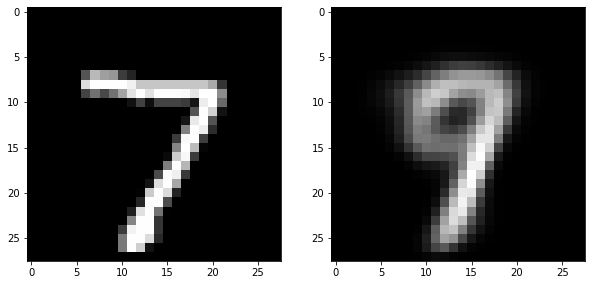

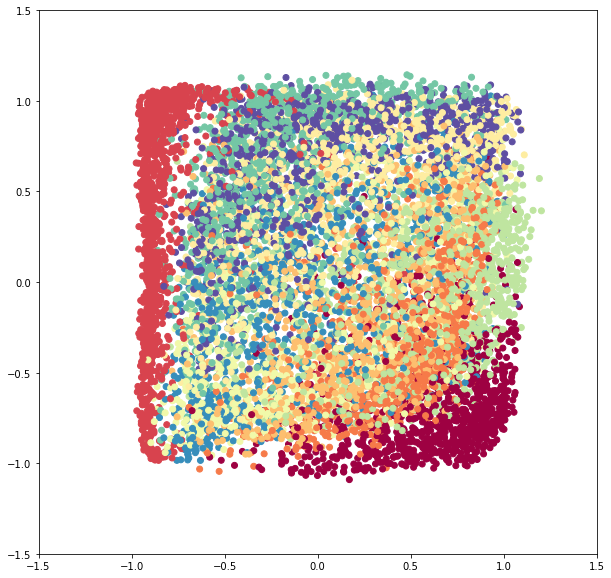

21 0.0004655058950185777 0.017915327075166635
22 0.00046492351144552233 0.018888834289635142
23 0.0004673374051849047 0.017140904396843796
24 0.00045987353225549057 0.016811922490120697
25 0.00046203813056151083 0.016666364531737927
26 0.00045987806593378425 0.01690085642575361
27 0.0004560810004671417 0.017147709261447475
28 0.0004560328798989458 0.01647089480365903
29 0.00045775087624788256 0.016838664310975388
30 0.0004635342093805473 0.01810263465352047


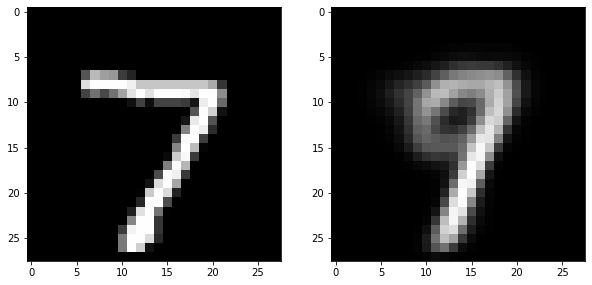

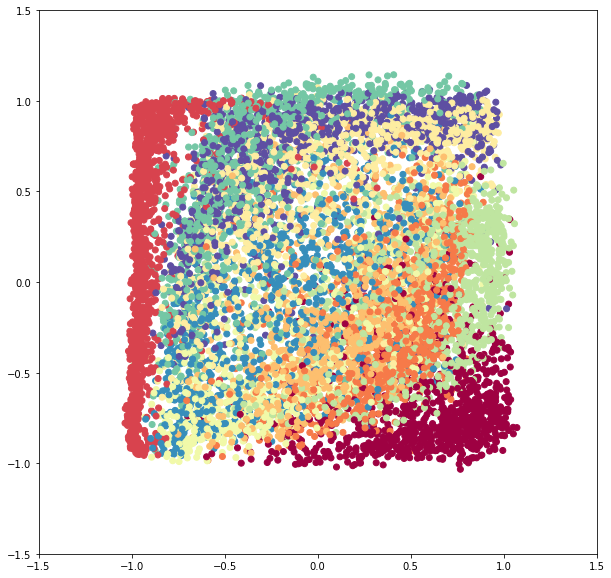

31 0.00045818451146284743 0.017406596278492063
32 0.000451498199502627 0.01749357871842175
33 0.0004547505274415016 0.017784488607590763
34 0.00044988523622353863 0.01656648937386636
35 0.00044633180697758995 0.016958653861388992
36 0.00044374357362588233 0.01622755671390139
37 0.00044476137508948633 0.01643619507241744
38 0.0004405186084409555 0.016516250058318287
39 0.0004484680602947869 0.016854223244772933
40 0.00044029717495044083 0.016511292277147975


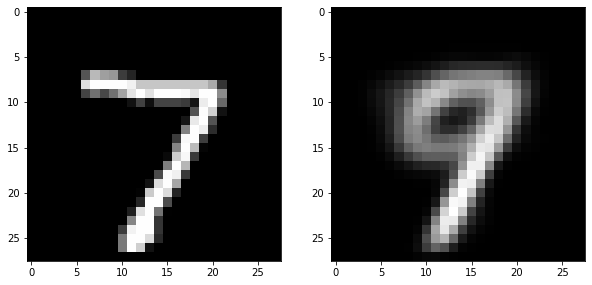

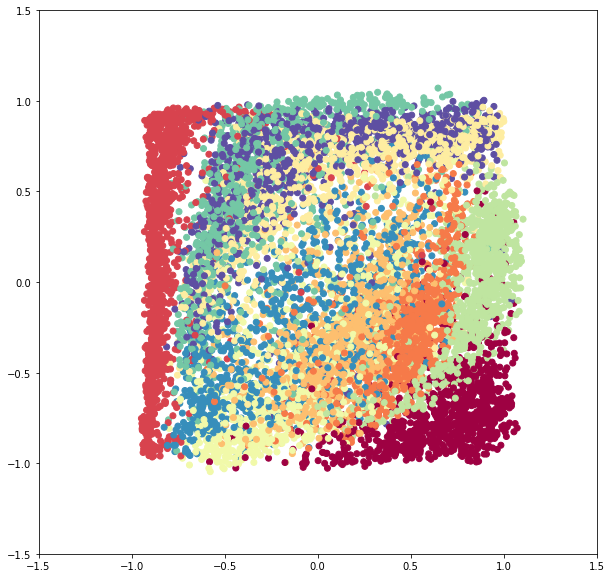

41 0.00044267015755176535 0.016464151561069795
42 0.00044179142837723107 0.01659940888349431
43 0.0004373204688231152 0.016617114953220654
44 0.0004382615633308887 0.015737641828890425
45 0.00043615594754616417 0.016088966634303047
46 0.00042984690293669704 0.01569246848563131
47 0.00043863770266373955 0.016972511521757792
48 0.00043156661589940383 0.01601916143057731
49 0.00042542395070195176 0.015729725289459047
50 0.0004329368365307649 0.016423446941561403


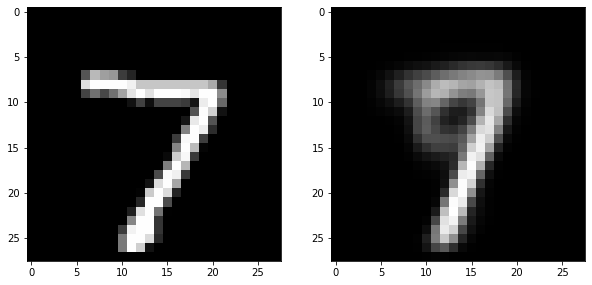

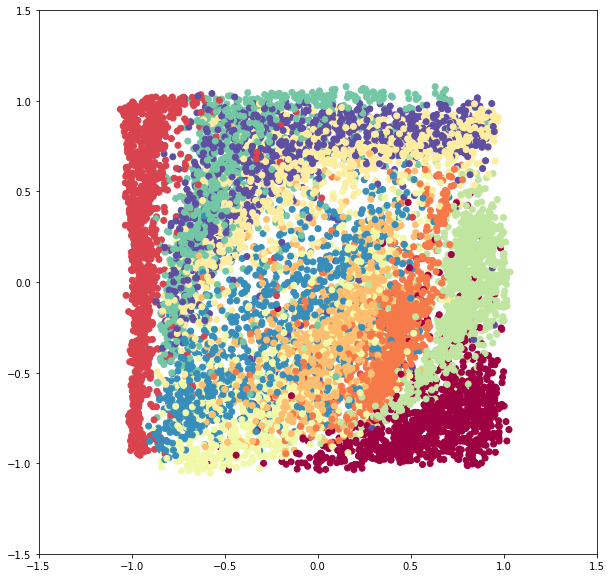

51 0.00043109708055853843 0.01682786419749641
52 0.00043499226197600376 0.016121587775552424
53 0.00042073725114266067 0.016450247661874126
54 0.00042363701735933623 0.015807244593438248
55 0.0004328575640916826 0.01545998141074333
56 0.0004198037932316461 0.016153826416967013
57 0.0004262503589193025 0.017102917956825073
58 0.0004191744476556778 0.016547929099835337
59 0.0004210779619713622 0.015888123442761054
60 0.00041633786434928585 0.016299808296723107


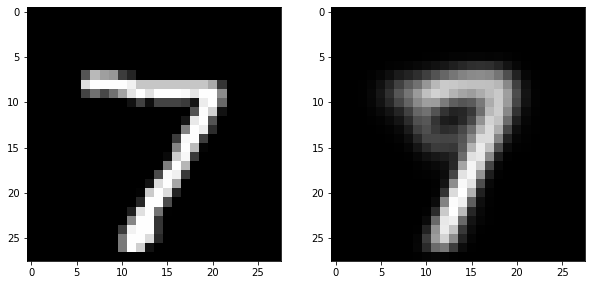

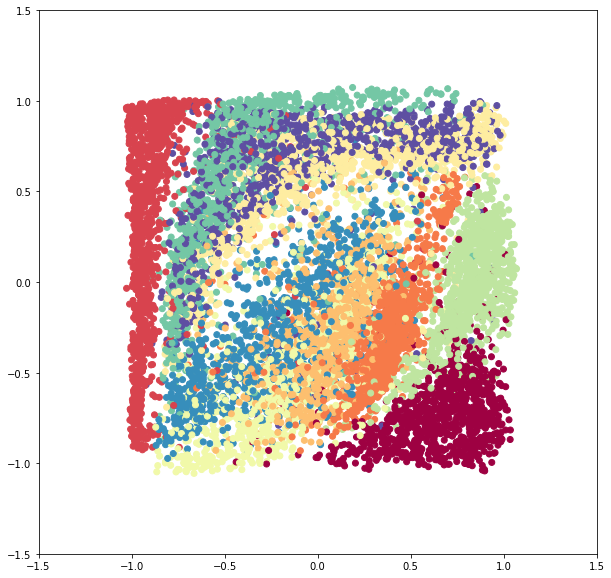

61 0.000415392939001322 0.01659053930352195
62 0.000426223869373401 0.01672761190754061
63 0.00042691535651683796 0.016662962609729447
64 0.0004177107592423755 0.015503754181721912
65 0.0004166375791033109 0.01627854854106522
66 0.00041005096783240647 0.017094916473633755
67 0.0004186801157891751 0.016122487912210413
68 0.0004187123998999596 0.016084941836020435
69 0.0004097849371532599 0.016777352987827298
70 0.0004125693197051683 0.016009992530075505


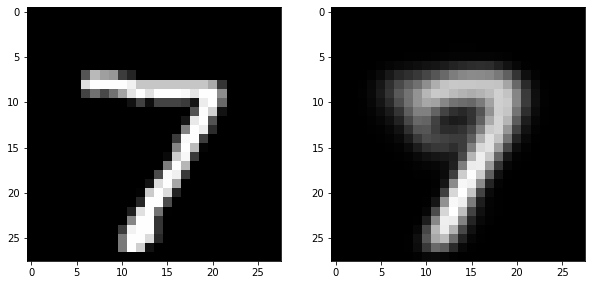

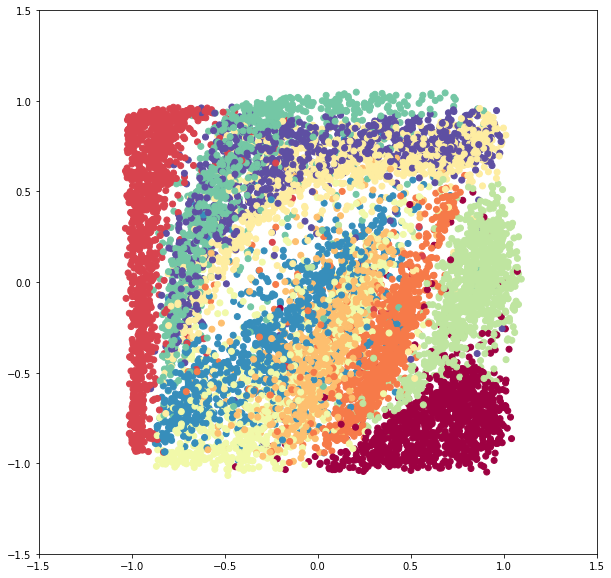

71 0.0004175070961316426 0.016777242908771996
72 0.00041113351310292863 0.015417701847399004
73 0.0004116630432506402 0.015690665213040078
74 0.0004095901076992354 0.015988777620723833
75 0.0004156711786985395 0.016185915106520676
76 0.0004070031555990374 0.015692020886943648
77 0.0004055143520236015 0.015816420331573523
78 0.0004056975133717061 0.01665281915602783
79 0.00040751281008124336 0.015984007658752294
80 0.00040878124833106983 0.015417672010858694


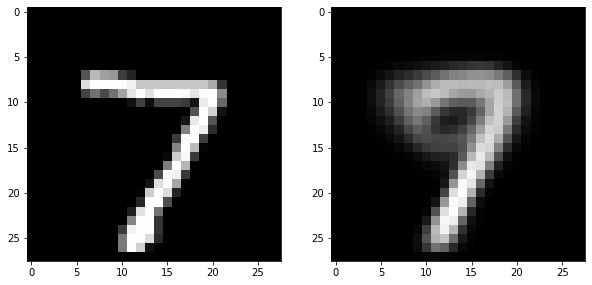

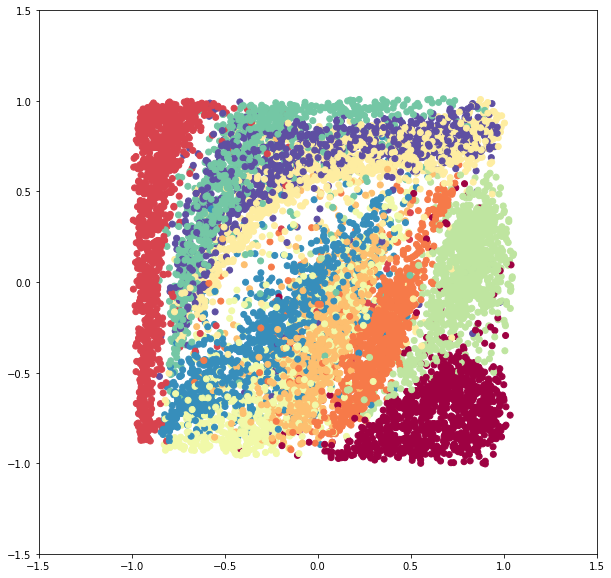

81 0.00040667859539389597 0.015626886526283364
82 0.0004087215110659599 0.015884614808443255
83 0.00040754944135745357 0.015380038124042006
84 0.0004004992534716926 0.015663288704777203
85 0.00040493516425291686 0.016113539437611644
86 0.0004030504778027535 0.01641972425777596
87 0.00040322929148872694 0.015157082150824154
88 0.00041330312813321737 0.015402031208450993
89 0.00040586301982402796 0.016045949320656994
90 0.0004038695792357126 0.015699340825001844


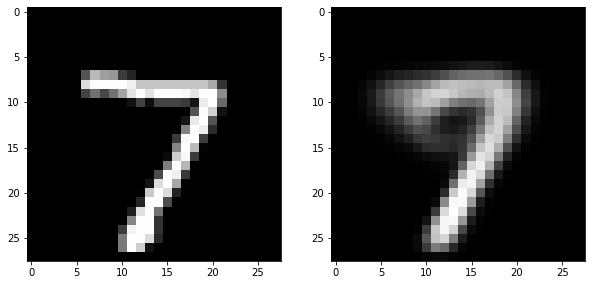

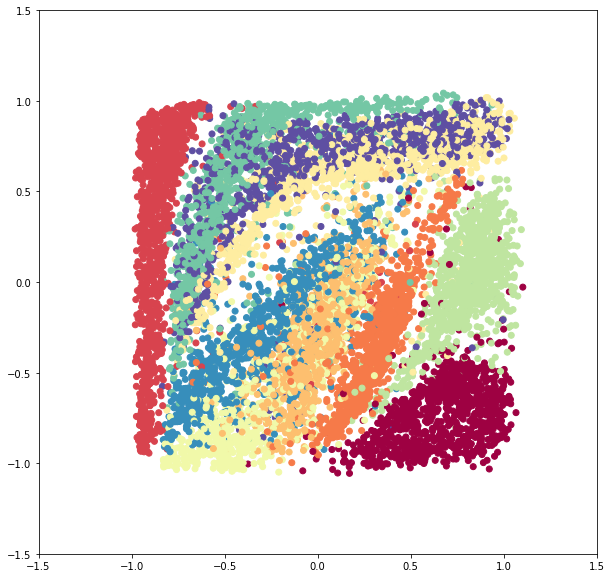

91 0.00040907949159542725 0.016217619487152883
92 0.0004021846026182173 0.015107652318244354
93 0.0004005894159277283 0.015510166318307574
94 0.0004042906035979588 0.01596140062894684
95 0.00040425193582971884 0.015487871995677773
96 0.0004011904639502367 0.015275702645151188
97 0.0004002045852442583 0.01611521998390603
98 0.00040291961207985903 0.015510329664253388
99 0.000396337213367224 0.01574206275169175
100 0.0004014319914082685 0.01574951963731275


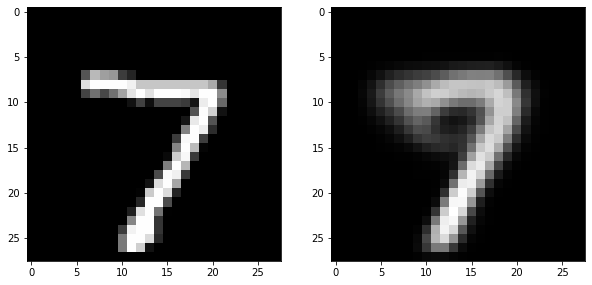

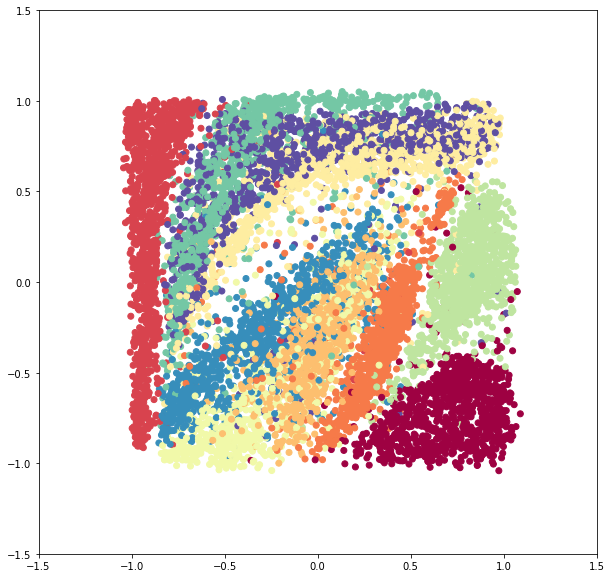

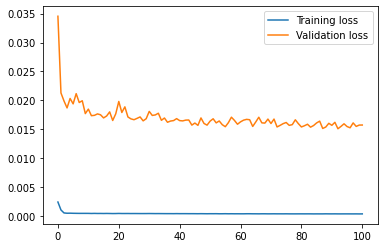

In [102]:
model = AE(16, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model, optimizer, 101, train_loader, test_loader, "unif", True)